<a href="https://colab.research.google.com/github/daviddelafuente17/Imagen_ant-genos_David_Guille/blob/main/res_net_leukemya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import shutil
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

# ==========================================
# 1. DESCARGAR DATASET (Si no está ya)
# ==========================================
print("⬇️ Descargando dataset completo desde Kaggle...")
path = kagglehub.dataset_download("mehradaria/leukemia")
print(f"📍 Dataset en caché: {path}")

# La ruta base suele ser .../Original/
source_root = Path(path) / "Original"

# ==========================================
# 2. CONFIGURACIÓN DE CLASES
# ==========================================
# AQUÍ ESTÁ LA CLAVE: Solo listamos las que queremos.
# Ignoramos "Early" a propósito.
target_classes = ["Benign", "Pre", "Pro"]

base_dir = Path(".") # Directorio actual

# ==========================================
# 3. LIMPIEZA Y ORGANIZACIÓN
# ==========================================
print("🧹 Limpiando carpetas de entrenamiento antiguas...")
for dir_name in ["train", "validation", "test"]:
    if (base_dir / dir_name).exists():
        shutil.rmtree(base_dir / dir_name)

print(f"📦 Extrayendo SOLO las clases: {target_classes}...")

for class_name in target_classes:
    # Buscamos la carpeta original (a veces se llaman 'Benign' o 'Benign_ALL', buscamos coincidencia)
    # Esto hace el script robusto si la carpeta se llama diferente.
    candidates = list(source_root.glob(f"*{class_name}*"))

    if not candidates:
        print(f"⚠️ ALERTA: No encuentro la carpeta para '{class_name}' en {source_root}")
        print(f"   Contenido disponible: {[d.name for d in source_root.iterdir() if d.is_dir()]}")
        continue

    # Tomamos la primera coincidencia (ej: "Original/Pro" o "Original/Pro_B")
    class_source = candidates[0]

    # Recopilar imágenes
    images = [f for f in class_source.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]

    if len(images) == 0:
        print(f"❌ La carpeta {class_source.name} está vacía.")
        continue

    print(f"   ✅ Clase '{class_name}': Encontradas {len(images)} imágenes en '{class_source.name}'")

    # División: 70% Train, 15% Val, 15% Test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Función auxiliar para copiar archivos
    def copy_files(file_list, split_name):
        dest_dir = base_dir / split_name / class_name
        dest_dir.mkdir(parents=True, exist_ok=True)
        for file in file_list:
            shutil.copy(file, dest_dir / file.name)

    copy_files(train_imgs, "train")
    copy_files(val_imgs, "validation")
    copy_files(test_imgs, "test")

print("\n🎉 ¡Organización completada!")
print(f"   Se ha ignorado cualquier otra carpeta (como 'Early').")

# Verificación rápida
import subprocess
try:
    print("\n📊 Estado final de las carpetas:")
    for split in ["train", "validation", "test"]:
        print(f"   📂 {split}: {os.listdir(base_dir / split)}")
except:
    pass

print("\n🚀 AHORA EJECUTA EL BLOQUE DE ENTRENAMIENTO.")

⬇️ Descargando dataset completo desde Kaggle...


100%|██████████| 110M/110M [00:00<00:00, 171MB/s] 

Extracting files...


📍 Dataset en caché: /root/.cache/kagglehub/datasets/mehradaria/leukemia/versions/1
🧹 Limpiando carpetas de entrenamiento antiguas...
📦 Extrayendo SOLO las clases: ['Benign', 'Pre', 'Pro']...
   ✅ Clase 'Benign': Encontradas 504 imágenes en 'Benign'
   ✅ Clase 'Pre': Encontradas 963 imágenes en 'Pre'
   ✅ Clase 'Pro': Encontradas 804 imágenes en 'Pro'

🎉 ¡Organización completada!
   Se ha ignorado cualquier otra carpeta (como 'Early').

📊 Estado final de las carpetas:
   📂 train: ['Pro', 'Pre', 'Benign']
   📂 validation: ['Pro', 'Pre', 'Benign']
   📂 test: ['Pro', 'Pre', 'Benign']

🚀 AHORA EJECUTA EL BLOQUE DE ENTRENAMIENTO.


In [ ]:
pip install transformers datasets torch torchvision evaluate scikit-learn accelerate

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoImageProcessor, ResNetForImageClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
from torchvision.transforms import Compose, Normalize, RandomResizedCrop, Resize, ToTensor, CenterCrop
import os
from transformers import EarlyStoppingCallback # <--- 1. Importar esto

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
# IMPORTANTE: Pon aquí la ruta a la carpeta QUE CONTIENE las carpetas 'train', 'val' y 'test'.
# Si usaste el script anterior, tus carpetas están en el directorio actual, así que usa "."
dataset_root = "."

# Definimos tus 3 etiquetas exactas
labels = ["Benign", "Pre", "Pro"]
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

print(f"⚙️ Configurando entrenamiento para: {labels}")

# ==========================================
# 2. CARGAR EL DATASET
# ==========================================
print("📂 Cargando imágenes...")
# 'imagefolder' busca automáticamente carpetas train/validation/test
dataset = load_dataset("imagefolder", data_dir=dataset_root)

# Si tu carpeta se llama 'val' en lugar de 'validation', a veces hay que renombrarla en el objeto dataset
if "validation" not in dataset and "val" in dataset:
    dataset["validation"] = dataset["val"]

print(f"✅ Dataset cargado: {dataset}")

# ==========================================
# 3. PREPROCESAMIENTO (CORREGIDO)
# ==========================================
checkpoint = "microsoft/resnet-50"
processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)

# Transformaciones
train_transforms_func = Compose([
    RandomResizedCrop(processor.size["shortest_edge"]),
    ToTensor(),
    normalize,
])

val_transforms_func = Compose([
    Resize(processor.size["shortest_edge"]),
    CenterCrop(processor.size["shortest_edge"]),
    ToTensor(),
    normalize,
])

# --- AQUÍ ESTABA EL ERROR ---
# Ahora incluimos 'del example_batch["image"]' para borrar la foto cruda
# y dejar solo los tensores matemáticos.

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms_func(image.convert("RGB")) for image in example_batch["image"]
    ]
    # CRITICO: Borramos la columna 'image' original para que no confunda al Trainer
    del example_batch["image"]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [
        val_transforms_func(image.convert("RGB")) for image in example_batch["image"]
    ]
    # CRITICO: Borramos la columna 'image' original
    del example_batch["image"]
    return example_batch

# Aplicar las transformaciones
# Nota: Si ya ejecutaste esto antes, es bueno limpiar el cache o recargar el dataset,
# pero sobrescribir el set_transform suele funcionar bien.
dataset["train"].set_transform(preprocess_train)
if "validation" in dataset:
    dataset["validation"].set_transform(preprocess_val)
if "test" in dataset:
    dataset["test"].set_transform(preprocess_val)

print("✅ Funciones de preprocesamiento corregidas (imágenes crudas eliminadas).")
# ==========================================
# 4. MODELO
# ==========================================
print("🧠 Descargando y configurando ResNet-50...")
model = ResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True # Esto permite cambiar de 1000 clases a 3
)

# ==========================================
# 5. METRICAS Y ENTRENAMIENTO (CORREGIDO)
# ==========================================
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Configuración del entrenamiento
training_args = TrainingArguments(
    output_dir="./resnet-50-finetuned-leucocitos",
    remove_unused_columns=False,

    # --- CAMBIO IMPORTANTE AQUÍ ---
    eval_strategy="epoch",  # Antes se llamaba 'evaluation_strategy'
    # ------------------------------

    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"] if "validation" in dataset else None,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

training_args = TrainingArguments(
    output_dir="./resnet-50-finetuned-leucocitos",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    num_train_epochs=15,             # <--- 2. Aumentar a 15

    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics,

    # 3. Añadir esto para que pare solo si no mejora
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("🚀 Re-entrenando con más potencia...")
trainer.train()


# ==========================================
# 7. GUARDADO FINAL
# ==========================================
print("💾 Guardando modelo final...")
save_path = "./modelo_final_entrenado"

trainer.save_model(save_path)
processor.save_pretrained(save_path)

print(f"✅ ¡LISTO! Modelo guardado en: {save_path}")

⚙️ Configurando entrenamiento para: ['Benign', 'Pre', 'Pro']
📂 Cargando imágenes...


Resolving data files:   0%|          | 0/1588 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/341 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/342 [00:00<?, ?it/s]

✅ Dataset cargado: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1588
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 341
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 342
    })
})
✅ Funciones de preprocesamiento corregidas (imágenes crudas eliminadas).
🧠 Descargando y configurando ResNet-50...


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-66631914.py:132: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/tmp/ipython-input-66631914.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Re-entrenando con más potencia...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.046200,1.067003,0.589443
2,0.869500,0.937521,0.794721
3,0.482000,0.586535,0.891496
4,0.358000,0.295006,0.976540
5,0.253800,0.161021,0.979472
6,0.113000,0.112305,0.982405
7,0.085300,0.076296,0.982405
8,0.043200,0.041667,0.994135
9,0.136000,0.036799,0.988270
10,0.076500,0.040459,0.991202


💾 Guardando modelo final...
✅ ¡LISTO! Modelo guardado en: ./modelo_final_entrenado


In [ ]:
!pip install matplotlib scikit-learn

Resolving data files:   0%|          | 0/1588 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/341 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/342 [00:00<?, ?it/s]

📥 Cargando modelo desde: ./modelo_final_entrenado
🧪 Evaluando el set de Test... (Paciencia, procesando imágenes una a una)


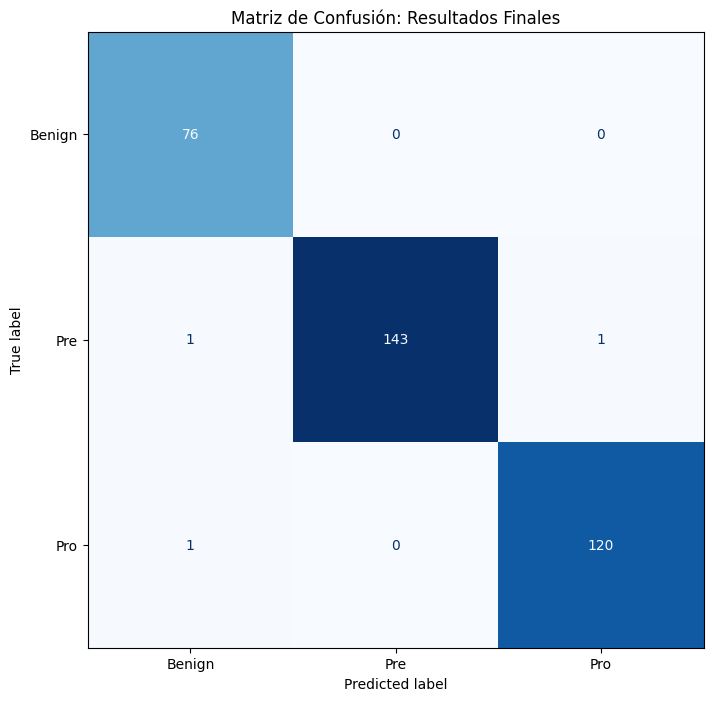


🏆 Precisión Final (Accuracy) en TEST: 99.12%


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoImageProcessor, ResNetForImageClassification
from datasets import load_dataset
import numpy as np

# ==========================================
# 1. CARGAR DATOS LIMPIOS Y MODELO
# ==========================================
# Volvemos a cargar el dataset para tener las imágenes originales (sin procesar)
dataset = load_dataset("imagefolder", data_dir=".")

path_modelo = "./modelo_final_entrenado"
print(f"📥 Cargando modelo desde: {path_modelo}")

model = ResNetForImageClassification.from_pretrained(path_modelo)
processor = AutoImageProcessor.from_pretrained(path_modelo)

# Usar GPU si hay
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# ==========================================
# 2. GENERAR PREDICCIONES
# ==========================================
print("🧪 Evaluando el set de Test... (Paciencia, procesando imágenes una a una)")

y_true = []
y_pred = []

# Iteramos sobre el dataset de test
for item in dataset["test"]:
    # Guardamos la etiqueta real
    y_true.append(item["label"])

    # Procesamos la imagen original
    # Convertimos a RGB para evitar problemas con imagenes en blanco y negro
    inputs = processor(item["image"].convert("RGB"), return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    # Obtenemos la predicción
    predicted_label = logits.argmax(-1).item()
    y_pred.append(predicted_label)

# ==========================================
# 3. GRAFICAR MATRIZ
# ==========================================
labels_names = dataset["test"].features["label"].names # ['Benign', 'Pre', 'Pro']
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)

# Dibujar
disp.plot(cmap='Blues', ax=ax, values_format='d', colorbar=False)
plt.title("Matriz de Confusión: Resultados Finales")
plt.show()

# Calcular Accuracy exacto
acc = np.sum(np.diag(cm)) / np.sum(cm)
print(f"\n🏆 Precisión Final (Accuracy) en TEST: {acc:.2%}")

📂 Recargando dataset para tener las imágenes originales...


Resolving data files:   0%|          | 0/1588 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/341 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/342 [00:00<?, ?it/s]

🧪 Evaluando el set de VALIDATION... (Procesando...)


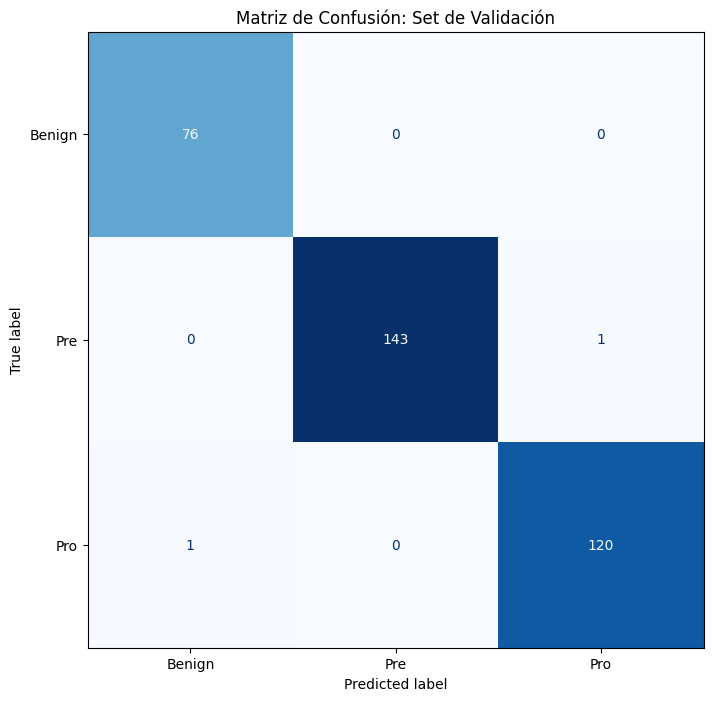


🏆 Precisión (Accuracy) en VALIDATION: 99.41%


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoImageProcessor, ResNetForImageClassification
from datasets import load_dataset
import numpy as np

# ==========================================
# 1. RECUPERAR IMÁGENES ORIGINALES
# ==========================================
# Cargamos de nuevo para asegurar que tenemos la columna 'image' (la foto cruda)
print("📂 Recargando dataset para tener las imágenes originales...")
dataset = load_dataset("imagefolder", data_dir=".")

# Cargar tu modelo
path_modelo = "./modelo_final_entrenado"
model = ResNetForImageClassification.from_pretrained(path_modelo)
processor = AutoImageProcessor.from_pretrained(path_modelo)

# Mover a GPU si existe
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# ==========================================
# 2. GENERAR PREDICCIONES (EN VALIDATION)
# ==========================================
print("🧪 Evaluando el set de VALIDATION... (Procesando...)")

y_true = []
y_pred = []

# AQUÍ ESTÁ EL CAMBIO: Usamos dataset["validation"]
for item in dataset["validation"]:
    # Guardamos la etiqueta real
    y_true.append(item["label"])

    # Procesamos la imagen
    inputs = processor(item["image"].convert("RGB"), return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    # Predicción
    predicted_label = logits.argmax(-1).item()
    y_pred.append(predicted_label)

# ==========================================
# 3. GRAFICAR RESULTADOS
# ==========================================
# Obtenemos los nombres de las clases
labels_names = dataset["validation"].features["label"].names # ['Benign', 'Pre', 'Pro']

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)

# Dibujamos en azul
disp.plot(cmap='Blues', ax=ax, values_format='d', colorbar=False)

plt.title("Matriz de Confusión: Set de Validación")
plt.show()

# Calcular Accuracy en Validación
acc = np.sum(np.diag(cm)) / np.sum(cm)
print(f"\n🏆 Precisión (Accuracy) en VALIDATION: {acc:.2%}")

🩺 Resultado: Benign (97.35%)


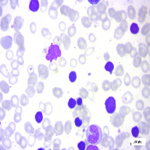

In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification
from PIL import Image
import torch
import torch.nn.functional as F

# 1. Cargar modelo
path_modelo = "./modelo_final_entrenado"
processor = AutoImageProcessor.from_pretrained(path_modelo)
model = ResNetForImageClassification.from_pretrained(path_modelo)

# 2. Ruta de la imagen (CAMBIA ESTO)
# Ejemplo: "/content/dataset/validation/Pre/imagen_ejemplo.jpg"
image_path = "/content/validation/Benign/WBC-Benign-019.jpg"

try:
    image = Image.open(image_path).convert('RGB')
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    pred_idx = logits.argmax(-1).item()
    pred_label = model.config.id2label[pred_idx]

    # Confianza
    probs = F.softmax(logits, dim=-1)
    conf = probs[0][pred_idx].item() * 100

    print(f"🩺 Resultado: {pred_label} ({conf:.2f}%)")
    display(image.resize((150,150)))

except Exception as e:
    print(f"Error: {e}")